In [2]:
from curses.ascii import isspace

%load_ext autoreload
%autoreload 2


import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import keras
import numpy as np
from graph import *
from encoder import create_encoder
import pandas as pd

from data_processing import processer
from semantic_clustering import *

from RepresentationLearner import RepresentationLearner
from compute import *
from GNN import *
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:


num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()


In [4]:
x_data = np.concatenate([x_train, x_test])
y_data = np.concatenate([y_train, y_test])

classes = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

In [5]:
x_data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [6]:
target_size = 32
representation_dims = 512
projection_units = 128
num_clusters = 28
kn = 5
tune_encoder_during_clustering = False

In [7]:
x_data = x_data.astype('float32')
processer.layers[-1].adapt(x_data)
x_data

array([[[[ 59.,  62.,  63.],
         [ 43.,  46.,  45.],
         [ 50.,  48.,  43.],
         ...,
         [158., 132., 108.],
         [152., 125., 102.],
         [148., 124., 103.]],

        [[ 16.,  20.,  20.],
         [  0.,   0.,   0.],
         [ 18.,   8.,   0.],
         ...,
         [123.,  88.,  55.],
         [119.,  83.,  50.],
         [122.,  87.,  57.]],

        [[ 25.,  24.,  21.],
         [ 16.,   7.,   0.],
         [ 49.,  27.,   8.],
         ...,
         [118.,  84.,  50.],
         [120.,  84.,  50.],
         [109.,  73.,  42.]],

        ...,

        [[208., 170.,  96.],
         [201., 153.,  34.],
         [198., 161.,  26.],
         ...,
         [160., 133.,  70.],
         [ 56.,  31.,   7.],
         [ 53.,  34.,  20.]],

        [[180., 139.,  96.],
         [173., 123.,  42.],
         [186., 144.,  30.],
         ...,
         [184., 148.,  94.],
         [ 97.,  62.,  34.],
         [ 83.,  53.,  34.]],

        [[177., 144., 116.],
       

In [8]:
encoder = create_encoder(
    representation_dims
)

In [ ]:
representation_learner = RepresentationLearner(encoder, projection_units, num_augmentations=4)

lr_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=500,
    alpha=0.1
)
optimizer = keras.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001)

representation_learner.compile(
    optimizer=optimizer,
    jit_compile=False,
)

history = representation_learner.fit(
    x=x_data,
    batch_size=512,
    epochs=50
)



Epoch 1/50


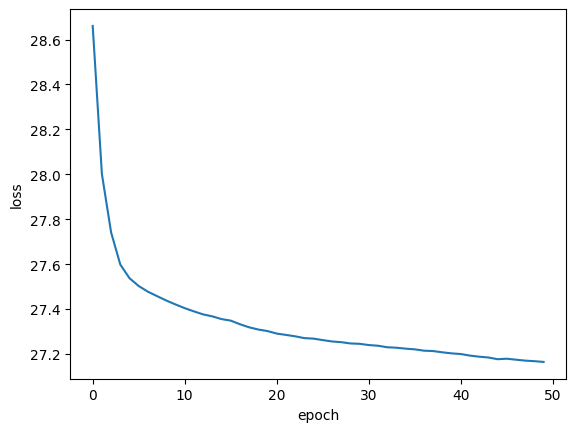

In [12]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [13]:
batch_size = 500
feature_vectors = encoder.predict(x_data, batch_size=batch_size, verbose=1)
feature_vectors = keras.utils.normalize(feature_vectors)


I0000 00:00:1748424852.327010    2013 service.cc:152] XLA service 0x7f9560035be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748424852.327039    2013 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-28 10:34:12.373611: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-28 10:34:13.549070: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1483', 4 bytes spill stores, 4 bytes spill loads

2025-05-28 10:34:13.679894: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1483_0', 108 bytes spill stores, 108 bytes spill loads

2025-05-28 10:34:13.754446: I ext

 13/120 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

I0000 00:00:1748424857.352924    2013 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step


In [14]:
knns = compute_knn(feature_vectors, batch_size=batch_size, kn=kn)


100%|██████████| 120/120 [00:04<00:00, 28.30it/s]


In [15]:
for layer in encoder.layers:
    layer.trainable = tune_encoder_during_clustering

clustering_model = create_clustering_model(encoder, num_clusters, input_shape, name='clustering')
clustering_learner = create_clustering_learner(clustering_model, input_shape)

losses = [ClustersEntropyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]

inputs = {"anchor": x_data, 'neighbours': tf.gather(x_data, knns)}
labels = [np.ones(shape=(x_data.shape[0], kn)), np.ones(shape=(x_data.shape[0], kn))]

clustering_learner.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.0001),
    loss=losses,
    jit_compile=False,
)

clustering_learner.fit(
    x=inputs,
    y=labels,
    batch_size=512,
    epochs=50
)



Epoch 1/50


2025-05-28 10:34:33.593011: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.80GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  1/118 ━━━━━━━━━━━━━━━━━━━━ 10:51 6s/step - clustering_loss: 0.1430 - loss: 0.9677 - simlarity_loss: 0.8248

2025-05-28 10:34:33.891134: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-28 10:34:33.966573: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.63GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - clustering_loss: 0.2393 - loss: 0.6224 - simlarity_loss: 0.3831
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - clustering_loss: 0.2844 - loss: 0.4345 - simlarity_loss: 0.1501
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - clustering_loss: 0.2969 - loss: 0.3523 - simlarity_loss: 0.0555
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - clustering_loss: 0.2810 - loss: 0.3353 - simlarity_loss: 0.0544
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - clustering_loss: 0.2829 - loss: 0.3317 - simlarity_loss: 0.0488
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - clustering_loss: 0.2848 - loss: 0.3312 - simlarity_loss: 0.0464
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - clustering_loss: 0.2798 - loss: 0.3313 - simlarity_loss: 0.0515
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - clustering_loss: 0.2725 - loss: 0.3266 - simlarity_loss: 0.0541
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s

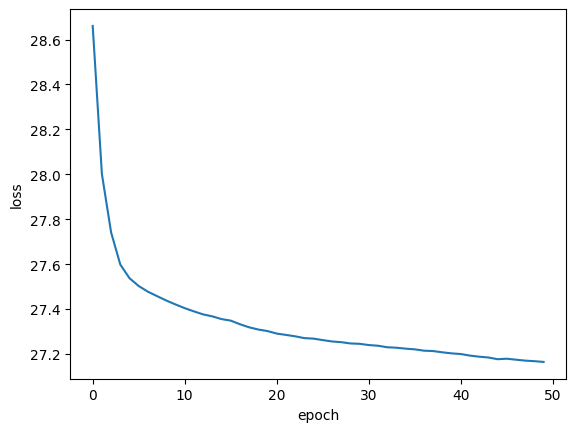

In [16]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


In [17]:
clustering_probabilitiys = clustering_model.predict(x_data, batch_size=batch_size)
cluster_assigment = keras.ops.argmax(clustering_probabilitiys, axis=-1).numpy()

cluster_confidence = keras.ops.max(clustering_probabilitiys, axis=-1).numpy()

120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


In [18]:
from collections import defaultdict

clusters = defaultdict(list)

for idx, c in enumerate(cluster_assigment):
    clusters[c].append((idx, cluster_confidence[idx]))

non_empty_clusters = defaultdict(list)

for c in clusters.keys():
    if clusters[c]:
        non_empty_clusters[c] = clusters[c]

for c in range(num_clusters):
    print(f"Cluster {c}:  {len(clusters[c])}")

Cluster 0:  1135
Cluster 1:  7491
Cluster 2:  1662
Cluster 3:  1694
Cluster 4:  1188
Cluster 5:  433
Cluster 6:  1166
Cluster 7:  1159
Cluster 8:  1539
Cluster 9:  810
Cluster 10:  2972
Cluster 11:  901
Cluster 12:  2284
Cluster 13:  1677
Cluster 14:  1552
Cluster 15:  1084
Cluster 16:  1733
Cluster 17:  1338
Cluster 18:  1548
Cluster 19:  11224
Cluster 20:  1922
Cluster 21:  1210
Cluster 22:  1917
Cluster 23:  4568
Cluster 24:  1613
Cluster 25:  1325
Cluster 26:  1634
Cluster 27:  1221


In [19]:
from sklearn.neighbors import NearestNeighbors

k = 5
cluster_knns = {}

for c, members in non_empty_clusters.items():
    indices = [idx for idx, _ in members]
    if len(indices) < k + 1:

        continue

    clutser_features = feature_vectors[indices]
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='auto').fit(clutser_features)

    distances, n_indices = nbrs.kneighbors(clutser_features)

    knns = [ [indices[n] for n in n[1:]] for n in n_indices]

    cluster_knns[c] = dict(zip(indices, knns))



In [20]:
type(cluster_knns)

dict

In [21]:
cluster_knns

{np.int32(19): {0: [52267, 10924, 16481, 13909, 32497],
  3: [20421, 31301, 30393, 19240, 26854],
  17: [59892, 6246, 32187, 50356, 20627],
  22: [19043, 34644, 17603, 17381, 28602],
  23: [19477, 52735, 27865, 31341, 28375],
  26: [54844, 24005, 53477, 38906, 4960],
  28: [34960, 40737, 4959, 49950, 49719],
  35: [22115, 378, 38723, 40033, 50593],
  41: [22535, 58782, 50370, 20287, 5613],
  52: [3897, 23420, 53526, 10134, 24846],
  56: [8065, 5129, 587, 34711, 39681],
  58: [59475, 57494, 20496, 16691, 4211],
  66: [4947, 35467, 22069, 2424, 36284],
  89: [33004, 8264, 16201, 16981, 45165],
  90: [50184, 2614, 46257, 25085, 24872],
  98: [12799, 47851, 18251, 14862, 35198],
  113: [31247, 11761, 56358, 34582, 34651],
  121: [45938, 21442, 10657, 26833, 23468],
  141: [8040, 41573, 42760, 38437, 35837],
  144: [48723, 44629, 39045, 19654, 50797],
  148: [49444, 55177, 15424, 23525, 26845],
  154: [50893, 50181, 30626, 18797, 9973],
  163: [3433, 7024, 27469, 10134, 22512],
  164: [2336

In [22]:
feature_vectors

array([[-0.05707311, -0.01878587, -0.01168191, ..., -0.08940852,
         0.10943574, -0.04173247],
       [-0.05716182, -0.01883268, -0.01148932, ..., -0.08936092,
         0.10891657, -0.04175788],
       [-0.05717058, -0.01883301, -0.01148881, ..., -0.08939317,
         0.108876  , -0.0417762 ],
       ...,
       [-0.05716451, -0.01886824, -0.01149561, ..., -0.08933181,
         0.10888851, -0.04173376],
       [-0.05719093, -0.01882253, -0.01153769, ..., -0.08933378,
         0.10894076, -0.04176734],
       [-0.05716209, -0.01881935, -0.01150681, ..., -0.08938608,
         0.10891069, -0.0417781 ]], dtype=float32)

In [23]:
feature_vectors = keras.utils.normalize(feature_vectors)


In [25]:
edge_list = []
for cluister in cluster_knns.values():
    for node, neighbors in cluster_knns.items():
        for neighbor in neighbors:
            edge_list.append([node, neighbor])

edge_list = np.array(edge_list)

In [26]:
edge_list

array([[   19,     0],
       [   19,     3],
       [   19,    17],
       ...,
       [    4, 59889],
       [    4, 59905],
       [    4, 59951]])

In [46]:
feature_vectors

array([[-0.05707311, -0.01878587, -0.01168192, ..., -0.08940853,
         0.10943574, -0.04173247],
       [-0.05716182, -0.01883268, -0.01148932, ..., -0.08936092,
         0.10891658, -0.04175789],
       [-0.05717058, -0.01883301, -0.01148881, ..., -0.08939317,
         0.108876  , -0.0417762 ],
       ...,
       [-0.05716451, -0.01886824, -0.01149561, ..., -0.08933181,
         0.10888851, -0.04173376],
       [-0.05719094, -0.01882253, -0.0115377 , ..., -0.08933379,
         0.10894077, -0.04176734],
       [-0.05716209, -0.01881935, -0.01150681, ..., -0.08938609,
         0.1089107 , -0.0417781 ]], dtype=float32)

In [82]:
hidden_units = 128
num_heads = 8
num_layers = 3
output_dim = len(classes)

num_epochs = 100
batch_size = 256
validation_split = 0.1
learning_rate = 3e-1
momentum = 0.9

In [83]:
type(y_data)

numpy.ndarray

In [84]:
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.SGD(learning_rate, momentum=momentum)
accuracy = keras.metrics.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-3,
    patience=5,
    restore_best_weights=True
)


In [85]:
node_states = tf.convert_to_tensor(feature_vectors, dtype=tf.float32)

In [86]:
model = GraphAttentionNetwork(
    node_states=node_states,
    edges=edge_list,
    hidden_units=hidden_units,
    num_heads=num_heads,
    num_layers=num_layers,
    output_dim=output_dim,
)

In [87]:
model.compile(
    loss=loss_fn,
    optimizer=optimizer,
    metrics=[accuracy],
)

In [88]:
feature_vectors.shape

(60000, 512)

In [89]:
y_data.shape

(60000,)

In [90]:
edge_list.shape

(1680000, 2)

In [91]:

train_indices = np.arange(len(y_data))
train_labels = y_data.flatten().astype(np.int32)


In [92]:
train_labels.shape

(60000,)

In [93]:
train_indices.shape

(60000,)

In [ ]:

model.fit(
    x=train_indices,
    y=train_labels,
    batch_size=None,
    epochs=num_epochs,
    callbacks=[early_stopping],
    verbose=2,
)